In [1]:
import matplotlib.pyplot as plt
import numpy as np

G = 6.67430e-11  # gravitational constant, m^3 kg^-1 s^-1
M = 5.972e24  # mass of Earth, kg
R = 6371e3  # radius of Earth, meters

In [2]:
altitude = 400e3  # altitude above Earth's surface, meters
radius_orbit = R + altitude  # orbital radius
velocity = np.sqrt(G * M / radius_orbit)  # orbital velocity

In [4]:
from mpl_toolkits.mplot3d import Axes3D

In [5]:
J2 = 1.08263e-3  # Earth's second zonal harmonic

In [6]:
Psr = 4.56e-6  # Solar radiation pressure at 1 AU, N/m^2

In [7]:
# Calculate orbital velocity for a circular orbit
velocity = np.sqrt(G * M / radius_orbit)

# Time step and total simulation time
dt = 10  # seconds
total_time = 86400 * 7  # simulate for 7 days

# Initial position (x, y, z) and velocity (vx, vy, vz)
pos = np.array([radius_orbit, 0, 0])
vel = np.array([0, velocity, 0])

# Satellite mass and drag properties
sat_mass = 1000  # kg
Cd = 2.2  # drag coefficient
A = 2.0  # cross-sectional area, m^2 (increased for visible solar pressure effects)
rho = lambda h: 1e-13 * np.exp(-h / 100000)  # exponential model of atmospheric density

# Lists to store satellite positions
positions = []


In [8]:
# Solar vector calculation
def get_sun_vector(day):
    theta = 2 * np.pi * day / 365.25
    return np.array([np.cos(theta), np.sin(theta), 0])

# Leapfrog (Symplectic) Integrator setup
pos += 0.5 * vel * dt  # kickstart the integrator


In [9]:
# Simulation loop
for t in range(0, total_time, dt):
    r = np.linalg.norm(pos)
    h = r - R  # altitude above Earth's surface

    if h < 0:
        print(f"Warning: Satellite crashed into Earth at t = {t} seconds.")
        break

    # Gravitational acceleration with J2 perturbation
    x, y, z = pos
    factor = -G * M / r**3
    j2_factor = J2 * (R**2 / r**4) * 1.5
    acc_gravity = factor * (1 - j2_factor * (5 * z**2 / r**2 - 1)) * pos - j2_factor * factor * np.array([0, 0, 2 * z])

    # Atmospheric drag
    v_mag = np.linalg.norm(vel)
    drag = -0.5 * Cd * A * rho(h) * v_mag / sat_mass * vel

    # Solar radiation pressure
    sun_vector = get_sun_vector(t // 86400)  # update direction each day
    solar_acc = -Psr * A / sat_mass * sun_vector

    # Update velocity and position with gravity, drag, and solar pressure
    vel += (acc_gravity + drag + solar_acc) * dt
    pos += vel * dt

    # Store position
    positions.append(pos.copy())


In [10]:
# Convert positions to a numpy array for easy plotting
positions = np.array(positions)


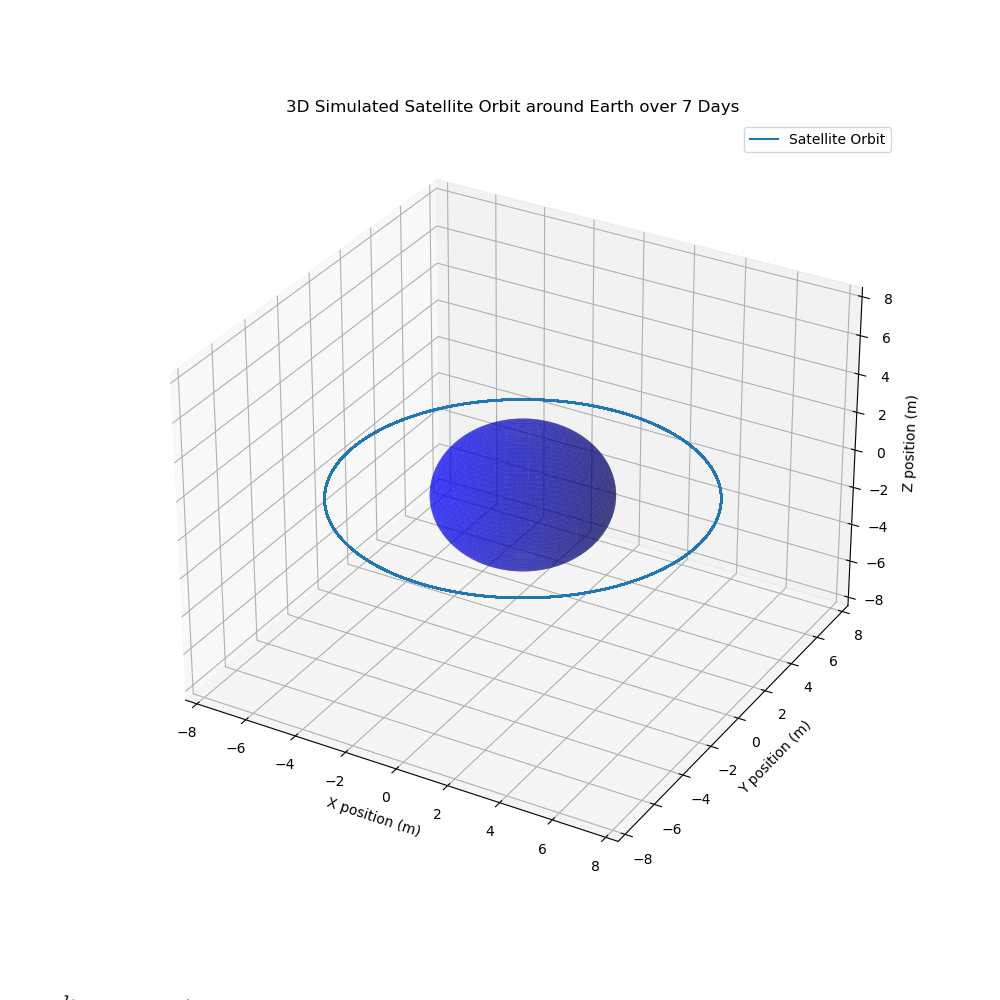

In [12]:
%matplotlib widget
# 3D plot of the orbit
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
#ax = Axes3D(fig)


# Draw the Earth as a 3D sphere with reduced size
visual_earth_radius = R * 0.5  # reduced for better visualization
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 50)
x = visual_earth_radius * np.outer(np.cos(u), np.sin(v))
y = visual_earth_radius * np.outer(np.sin(u), np.sin(v))
z = visual_earth_radius * np.outer(np.ones(np.size(u)), np.cos(v))
ax.plot_surface(x, y, z, color='b', alpha=0.5)

# Plot the orbit
ax.plot(positions[:, 0], positions[:, 1], positions[:, 2], label='Satellite Orbit')
ax.set_xlabel('X position (m)')
ax.set_ylabel('Y position (m)')
ax.set_zlabel('Z position (m)')
ax.set_title('3D Simulated Satellite Orbit around Earth over 7 Days')
ax.legend()

# Set equal aspect ratio and scaling
max_radius = radius_orbit * 1.2
ax.set_xlim([-max_radius, max_radius])
ax.set_ylim([-max_radius, max_radius])
ax.set_zlim([-max_radius, max_radius])

plt.show()